**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
            6) 활성
            7) 리텐션
        2. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
from scipy.stats import pearsonr
import difflib

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

#-------------------#
# pickle
#-------------------#
sys.path.append("/home/minkyung62/analysis_report/00_custom_analysis/kto_custom/notebook_git/return_pickle.py")
import return_pickle
from return_pickle import *
for pkg in [return_pickle] :
    _ = importlib.reload(pkg)


# 1.Data Import

In [4]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
CheckDate.check_date_return_pickle(e_date='20221130', s_date=s_date)
df_app_log = ReadFile.read_pickle(e_date='20221130', s_date=s_date)

# df_app_log = DataImport.read_files(
#     input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
#     today = datetime.strptime('20221118', '%Y%m%d') + timedelta(days = 1), 
#     dates = (datetime.strptime('20221118', '%Y%m%d') - datetime.strptime('20221110', '%Y%m%d')).days + 1,
#     platform_total = True, reduce_memory = True, verbose = False)

df_app_log_copy = df_app_log.copy()        ## copy code

df_app_log_before = DataImport.set_date_range(df = df_app_log, start= datetime(2022,10,1), end = advertisement_date)
df_app_log_after = DataImport.set_date_range(df = df_app_log, start= advertisement_date, end = datetime(2022,11,27))

# 2.Preprocess

In [5]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) basic prep
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)   

## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER], drop_none_prop=False)       # user data

## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [6]:
# df_gudok_campaign_subscribe_done = df_gudok_campaign[df_gudok_campaign['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)]
# pd.set_option('max_rows', 100)
# df_gudok_campaign_subscribe_done.groupby(['referrer_utm_source', 'day']).size().to_frame()
# pd.set_option('max_rows', 30)

In [7]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
# df_param_install = DataImport.extract_event_param(df_param_all, EVENT_APP_INSTALL).drop_duplicates()
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter =\
     df_param_all[df_param_all[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

In [8]:
df_param_contents_letter[PARAM_CONTENT_NAME].unique()

array(['가볼래-터 구독하러 가기', "여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★",
       '여행을 구독하세요!✨가볼래-터 10월호 Open✨',
       '핫플레이스와 신상 여행정보가 가득 담긴＇가볼래-터＇구독 신청하고 매월 초간단 미션을 완료하면 특별한 선물이 담긴 여행복권을 드립니다!',
       '여행구독 서비스! 가볼래-터 10월호 Open!',
       '매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!',
       '매월 당신의 눈앞에 여행을 배송!가볼래-터 구독하러가기!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사 당첨자 발표',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사',
       '＇가볼래-터＇구독 신청하고 미션 선물받자!', '여행구독 서비스! 가볼래-터 11월호 Open!',
       '여행을 구독하세요!❄가볼래-터 11월호 Open❄',
       '매월 당신의 눈앞에 여행을 배송!매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!여행구독 <가볼래-터> 구독하러가기!',
       '매월 당신의 눈앞에 여행을 배송!★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★!매월 당신의 눈앞에 여행을 배송!★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★!여행구독 <가볼래-터> 구독하러가기!★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★!여행구독 <가볼래-터> 구독하러가기!★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★!'],
      dtype=object)

## 1)Utils

In [9]:
# cnt -> percent function
def cnt_to_percent_ver1(df, col):
    df[col] = df[col].astype(float)

    if  df.index.dtype != 'str':
        df.index = df.index.astype('str')
    
    _lst = []
    for i in range(0,len(df)):
        x = round((df[col][i] / df[col].sum())*100, 2)
        _lst.append(x)

    df['percent']= _lst
    return df


def get_daily_cnt(
                  dict_output, lst, nm, dict_input, df_target = df_app_log, KEY_ID = KEY_ID_DEVICE, 
                  make_sub_dict = False):
    # 1. 전체 일별 수치
    _df_target_daily = df_target[df_target[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_target[df_target[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        _df_target_daily[f'{key}'] = _df[f'{key}_{nm}']
        _df_target_daily.fillna(0, inplace=True)
        # pd.concat([_df_target_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return _df_target_daily

# 3.Analysis
## 0)Segment Setting

In [10]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
dict_lst_user_from_referrs_gudok['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
df_app_log['created_date'] = pd.DatetimeIndex(df_app_log['created_date'])
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_duration_per_device[df_duration_per_device < 5].index)
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
# ## gender
# dict_seg_gender = dict()
# dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
# dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

# ## age
# dict_seg_age = dict()
# # dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
# # dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# # # # ======================================================== #  next version
# dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

In [11]:
## prep referr 
#   FB_INSTA : instagram & FB_INSTA & Facebook
#   KAKAO_moment : kakao_mo & KAKAO_moment
#   kakaotalk_bizmessage --> 제외 (카카오 알림톡)
dict_lst_user_from_referrs_gudok['KAKAO_moment'] =\
    list(
        set(dict_lst_user_from_referrs_gudok['kakao_mo'] + dict_lst_user_from_referrs_gudok['KAKAO_moment'])
        )
dict_lst_user_from_referrs_gudok['FB_INSTA'] =\
    list(    
        set(dict_lst_user_from_referrs_gudok['instagram'] + dict_lst_user_from_referrs_gudok['FB_INSTA']+\
            dict_lst_user_from_referrs_gudok['Facebook'])
    )

del dict_lst_user_from_referrs_gudok['kakaotalk_bizmessage']
del dict_lst_user_from_referrs_gudok['kakao_mo']
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['Facebook']

dict_lst_user_from_referrs_gudok.keys()

dict_keys(['NAVER_GFA', 'KAKAO_moment', 'FB_INSTA', 'GDN', 'organic'])

## 1)매체 성과 분석
### (1)유입
- 전체 유입
- 일별 유입
    - 전체 유입
    - 신규 유입
    - 기존 유입

In [12]:
#########################################
# 1. 매체별 전체 유입인원
## 전체 / 일별 총 유입인원
#########################################
dict_output_inflow_total= {}
dict_output_inflow_daily= {}

def count_inflow(dict_input, dict_output_total, dict_output_daily, KEY_ID = KEY_ID_DEVICE, 
    lst = list(df_app_log[KEY_ID_DEVICE].unique()), nm = 'inflow'):
    _df_target_daily = df_app_log[
                        df_app_log[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                            .nunique().to_frame(name = f'total_{nm}')

    for _referrer, _segment in dict_input.items():
        ## 1) 전체 총 유입인원
        dict_output_total[f'{_referrer}'] = {}
        dict_output_total[f'{_referrer}'][f'{nm}'] = len(set(_segment))

        ## 2) 일별 총 유입인원
        _lst_segment = list(set(lst) &  set(_segment))
        _df = df_app_log[df_app_log[KEY_ID].isin(_lst_segment)].groupby('day')[KEY_ID].nunique().to_frame(name = f'{_referrer}').fillna(0)
        
        dict_output_daily[f'{_referrer}'] = {}
        dict_output_daily[f'{_referrer}'][f'{nm}'] = _df
        _df_target_daily[f'{_referrer}'] = _df[f'{_referrer}']
        _df_target_daily.fillna(0, inplace=True)


    ### 1-2) 전체 총 유입인원 df화
    _df_output = pd.DataFrame.from_dict(dict_output_total, orient='index', columns=['inflow'])
    _df_output = cnt_to_percent_ver1(_df_output, 'inflow')
    _df_output = _df_output.sort_values(by = 'inflow', ascending=False)

    return _df_output, _df_target_daily

_df_inflow_total, _df_inflow_daily = count_inflow(dict_lst_user_from_referrs_gudok, dict_output_inflow_total, dict_output_inflow_daily)
_df_inflow_total
pd.set_option('max_rows', 100)
_df_inflow_daily

,inflow,percent
organic,2265472.0,95.41
GDN,35388.0,1.49
NAVER_GFA,32604.0,1.37
KAKAO_moment,21449.0,0.90
FB_INSTA,19625.0,0.83


,total_inflow,NAVER_GFA,KAKAO_moment,FB_INSTA,GDN,organic
day,,,,,,
2022-10-20,67791,985,532,735,1209,63640
2022-10-21,73369,1062,575,637,161,70481
2022-10-22,93591,1066,533,870,291,90464
2022-10-23,83871,1025,729,1010,1767,78995
2022-10-24,68504,1080,712,693,1264,64277
2022-10-25,64629,1016,661,685,1191,59633
2022-10-26,60004,906,620,591,623,56714
2022-10-27,50872,871,570,518,1694,46908
2022-10-28,74168,881,632,540,1185,70620


In [13]:
# #########################################
# # 2. 일별 유입
# #########################################
# ## 2) 신규 유입
# df_daily_new_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_new_device, nm='new_inflow', 
#                     dict_input = dict_lst_user_from_referrs_gudok)
# df_daily_new_inflow

# ## 3) 기존 유입
# df_daily_re_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_re_device, nm='re_inflow',
#                     dict_input=dict_lst_user_from_referrs_gudok)
# df_daily_re_inflow

### (2)재방문
- 방문 빈도별 재방문율
- 주차별 재방문율

,index,only_1_visit_rate,re_visit_rate,re_visit_over_3_rate
0,GDN,0.8373,0.1627,0.0649
1,FB_INSTA,0.8531,0.1469,0.0364
2,organic,0.8722,0.1278,0.0614
3,NAVER_GFA,0.8860,0.1140,0.0390
4,KAKAO_moment,0.9068,0.0932,0.0311


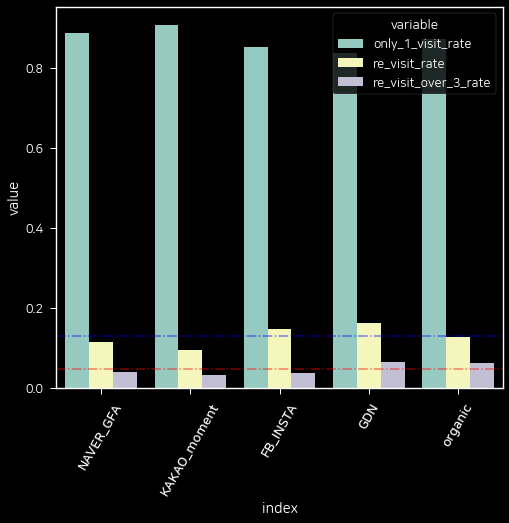

In [14]:
#------------------------------------------------#
## 2. 재방문율
#------------------------------------------------#
### 1) 1회 / 2회 이상 / 3회 이상 방문자
dict_output_revisit = dict()

#### count revisit rate
def revisit_rate(dict_input, dict_output):
    for _referrer, _segment in dict_input.items():
        dict_output[_referrer] = dict()
        _df_user_day_cnt = df_app_log[df_app_log[KEY_ID_DEVICE].isin(_segment)].groupby(KEY_ID_DEVICE)['day'].count()

        only_1_visit_rate = round(_df_user_day_cnt.value_counts()[1] / len(_segment), 4)
        re_visit_rate = round(1 - only_1_visit_rate, 4)
        re_visit_over_3_rate = round(1 - _df_user_day_cnt.value_counts()[:2].sum() / len(_segment), 4)
        
        dict_output[_referrer]['only_1_visit_rate'] = only_1_visit_rate
        dict_output[_referrer]['re_visit_rate'] = re_visit_rate
        dict_output[_referrer]['re_visit_over_3_rate'] = re_visit_over_3_rate

    _df_output = pd.DataFrame.from_dict(
        dict_output, orient = 'index'
        ).sort_values(by = 're_visit_rate', ascending=False).reset_index()
    
    return _df_output

df_ouput_revisit = revisit_rate(dict_lst_user_from_referrs_gudok, dict_output_revisit)
df_ouput_revisit

#### prep for vis
df_vis_1_2_retention = pd.DataFrame.from_dict(
    dict_output_revisit, orient = 'index'
    ).reset_index().melt(id_vars='index')
avg_rate_re_visit_over_2 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_rate'].mean().value
avg_rate_re_visit_over_3 = df_vis_1_2_retention[
    df_vis_1_2_retention['variable'] == 're_visit_over_3_rate'].mean().value

#### vis
ax = sns.barplot(
    data = df_vis_1_2_retention.reset_index(),
    x = 'index', y = 'value',
    capsize = 2 , alpha = 1, hue = 'variable'
    )
_ = plt.xticks(rotation=60, fontproperties = fprop)
_ = plt.axhline(y=avg_rate_re_visit_over_2, color='blue', ls = '-.', alpha = 0.5, label = 'a')
_ = plt.axhline(y=avg_rate_re_visit_over_3, color='red', ls = '-.', alpha = 0.5, label = 'a')
plt.show()

### (3)구독전환
- 구독전환수
- 구독전환율

In [15]:
#########################################
# 1. 구독완료
## 1) 일별 구독완료 유저 수
## 2) 구독전환율
#########################################
dict_output_subscribe = {}
df_daily_subscribe = pd.DataFrame()
df_subscribe_conversion = pd.DataFrame(index=[
                                'landing_cnt', 
                                'subscribe_cnt', 
                                'subscribe_conversion'])

def count_subscribe_conversion(dict_input, dict_output, df_output_daily, df_output_conversion, KEY_ID = KEY_ID_DEVICE):
    _df_log_target = df_app_log[
        df_app_log['abs_events'].apply(
            lambda x : True if EVENT_SUBSCRIBE in x else False
            )]

    df_output = _df_log_target.groupby('day')[KEY_ID].nunique().to_frame(name = 'total_cnt')
    _lst_device = list(_df_log_target[KEY_ID].unique())

    for _referrer, _segment in dict_input.items():
        ### 2) 매체별 일별 구독완료 유저 수
        _lst_target = list(set(_lst_device) &  set(_segment))

        _df = _df_log_target[_df_log_target[KEY_ID].isin(_segment)].groupby('day')[KEY_ID].nunique().to_frame(name = f'{_referrer}_subscribe_cnt').fillna(0)

        dict_output_subscribe[f'{_referrer}'] = {}
        dict_output_subscribe[f'{_referrer}']['subscribe_cnt'] = _df
        df_output[f'{_referrer}'] = _df[f'{_referrer}_subscribe_cnt']
        df_output.fillna(0, inplace=True)

        ### 3) 구독전환율
        landing_cnt = len(_segment)
        _df = df_param_subscribe[df_param_subscribe[KEY_ID_DEVICE].isin(_segment)]
        subscribe_cnt = _df[KEY_ID_DEVICE].nunique()
        dict_output[f'{_referrer}']['subscribe_conversion'] = [landing_cnt,
                                                        subscribe_cnt, 
                                                        (subscribe_cnt/landing_cnt)]

        df_output_conversion[f'{_referrer}'] = dict_output[f'{_referrer}']['subscribe_conversion']
        
    return df_output, df_output_conversion

df_daily_subscribe, df_subscribe_conversion =count_subscribe_conversion(
                                                dict_lst_user_from_referrs_gudok, dict_output_subscribe, 
                                                df_daily_subscribe, df_subscribe_conversion)

pd.set_option('max_rows', 100)
df_daily_subscribe
df_subscribe_conversion

,total_cnt,NAVER_GFA,KAKAO_moment,FB_INSTA,GDN,organic
day,,,,,,
2022-10-20,93,3.0,0.0,11.0,1.0,76
2022-10-21,70,7.0,0.0,9.0,0.0,54
2022-10-22,70,2.0,0.0,8.0,0.0,60
2022-10-23,75,5.0,0.0,11.0,1.0,59
2022-10-24,55,2.0,0.0,10.0,1.0,42
2022-10-25,50,2.0,2.0,7.0,0.0,43
2022-10-26,51,2.0,0.0,11.0,0.0,38
2022-10-27,53,6.0,0.0,7.0,0.0,38
2022-10-28,47,4.0,0.0,7.0,0.0,38


,NAVER_GFA,KAKAO_moment,FB_INSTA,GDN,organic
landing_cnt,32604.000000,21449.000000,19625.000000,35388.000000,2.265472e+06
subscribe_cnt,138.000000,81.000000,424.000000,13.000000,1.840000e+03
subscribe_conversion,0.004233,0.003776,0.021605,0.000367,8.121928e-04


### (4)Fraud
- 바운스율
- 정착율

In [16]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율
#########################################
dict_fraud_referrs = {}

def count_fraud(dict_input, dict_output, lst_fraud = lst_fraud_device):
    for _referrer, _segment in dict_input.items():
        _lst_device= list(set(_segment) & set(lst_fraud))       ## 수정된 부분
        
        total_cnt = len(_segment)
        fraud_cnt = len(_lst_device)
        settle_cnt = total_cnt - fraud_cnt
        fraud_rate = fraud_cnt / total_cnt
        settle_rate = 1 - fraud_rate                                

        dict_output[f'{_referrer}'] = [total_cnt, fraud_cnt, settle_cnt, fraud_rate, settle_rate]

    _df_output = pd.DataFrame.from_dict(
        dict_output, orient='index', columns=[
            'total_cnt', 'fraud_cnt', 'settle_cnt', 'fraud_rate', 'settle_rate']).sort_values(by = 'fraud_rate', ascending = False)
    
    return _df_output, dict_output

df_fraud_referrs, dict_fraud_referrs = count_fraud(dict_lst_user_from_referrs_gudok, dict_fraud_referrs)
df_fraud_referrs

,total_cnt,fraud_cnt,settle_cnt,fraud_rate,settle_rate
KAKAO_moment,21449,19327,2122,0.901068,0.098932
NAVER_GFA,32604,28884,3720,0.885904,0.114096
FB_INSTA,19625,16139,3486,0.822369,0.177631
GDN,35388,27970,7418,0.790381,0.209619
organic,2265472,1757017,508455,0.775563,0.224437


### (5)앱설치 유저

In [17]:
# #########################################
# 0. prep
# #########################################
EVENT_APP_INSTALL = '#appInstall'
app_key_android = 'qsJfZhE2Ft85SvZoXInoo3'
app_key_ios = 'qsJfZhE2Ft85SvZTOvxsUA'

#########################################
# 1. 앱설치 유저
#########################################
dict_install = {}

def count_app_install(dict_input, dict_output):
    # _df_log_install = df_app_log[df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)]

    for _referrer, _segment in dict_input.items():
        ## 1) 캠페인 유저의 사용자 ID 추출
        _lst_campaign_user_id = list(set(df_prop[df_prop[KEY_ID_DEVICE].isin(_segment)][KEY_ID_USER]))
        
        ## 2) 캠페인 유저의 사용자 ID중 android & ios 앱 사용자
        dict_output[f'{_referrer}'] = {}
        _lst_campaign_user_ids =\
            list(
                df_app_log[
                (df_app_log['app_key'].isin([app_key_android, app_key_ios])) & 
                (df_app_log[KEY_ID_USER].isin(_lst_campaign_user_id))
                ][KEY_ID_USER].unique()
                )
            # _df_log_install[_df_log_install[KEY_ID_USER].isin(_lst_user_id)][KEY_ID_USER]

        dict_output[f'{_referrer}'] = len(_lst_campaign_user_ids)

    df_output = pd.DataFrame.from_dict(
                    dict_output, orient='index', columns= ['install_cnt'])

    return df_output, dict_output

df_install_referrs, dict_install = count_app_install(dict_lst_user_from_referrs_gudok, dict_install)
df_install_referrs

,install_cnt
NAVER_GFA,54
KAKAO_moment,19
FB_INSTA,125
GDN,7
organic,8832


### (6)활성
- 인당 체류 시간
- 인당 컨텐츠 조회수
- 검색 조회 빈도

In [18]:
#########################################
# 1. 인당 체류시간
#########################################
dict_duration = {}
dict_events_cnt_output = {}

def activation(dict_input, dict_ouput1, dict_output2, KEY_ID = KEY_ID_DEVICE):
    lst_device_no_fraud = list(set(lst_total_device) - set(lst_fraud_device))
    _df_log_no_fraud = df_app_log[df_app_log[KEY_ID].isin(lst_device_no_fraud)]

    for _referrer, _segment in dict_input.items():
        ## 1) 평균 체류 시간
        _df = _df_log_no_fraud[_df_log_no_fraud[KEY_ID_DEVICE].isin(_segment)]
        dict_ouput1[f'{_referrer}']= _df.groupby(KEY_ID)['duration'].sum().mean()

        ## 2) 평균 컨텐츠 조회수
        _df_app_log_by_referr = df_app_log[
                                    df_app_log[KEY_ID_DEVICE].isin(_segment)]
        _df_app_log_by_referr['events_cnt'] = _df_app_log_by_referr['abs_events'].apply(lambda x : len(x))

        dict_output2[f'{_referrer}'] = _df_app_log_by_referr.groupby(KEY_ID_DEVICE)['events_cnt'].sum().mean()

    ### 1-2) 평균 체류 시간 df화
    _df_output1 = pd.DataFrame.from_dict(dict_ouput1, orient='index', columns=['average_duration'])
    _df_output1 = _df_output1.sort_values(by = 'average_duration', ascending=False)

    ### 2-2) 평균 컨텐츠 조회수 df화
    _df_output2 = pd.DataFrame.from_dict(dict_output2, orient='index',  columns=['average_event_cnt'])

    return _df_output1, _df_output2

df_duration, df_event_cnt = activation(dict_lst_user_from_referrs_gudok, dict_duration, dict_events_cnt_output)
df_duration
df_event_cnt

,average_duration
GDN,452.130182
NAVER_GFA,395.244230
organic,359.414812
KAKAO_moment,302.031015
FB_INSTA,152.825649


,average_event_cnt
NAVER_GFA,1.741688
KAKAO_moment,1.521236
FB_INSTA,2.111032
GDN,1.701283
organic,2.382553


In [19]:
# #########################################
# # 3. 인당 검색 조회 빈도
# #########################################
# ## 1) 랜딩페이지 접속 유저
# ### 이상 유저 포함
# _df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

# dict_search = {}
# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 포함'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 포함): ', round(dict_search[f'{key}_이상 유저 포함'], 2), '회')

# print('-'*50)

# ### 이상 유저 제거 --> 차이 없음!
# _df_log_target_no_fraud =\
#      _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

# for key, values in dict_lst_user_from_referrs_gudok.items():
#     _df = _df_log_target_no_fraud[_df_log_target_no_fraud[KEY_ID_DEVICE].isin(values)]
#     _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
#     dict_search[f'{key}_이상 유저 제거'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
#     print(f'{key} 인당 검색 조회 빈도(이상 유저 제거): ', round(dict_search[f'{key}_이상 유저 제거'] , 2), '회')